# Formula One Project: Modeling

DUE: December 4th, 2024 (Wed)  
Name(s): Sean O'Connor, Connor Coles    
Class: CSCI 349 - Intro to Data Mining  
Semester: Fall 2024  
Instructor: Brian King  

## Assignment Description

Copy over the important cells from the previous step that read in and cleaned your data to this new notebook file. You do not need to copy over all your EDA and plots describing your data, only the code that prepares your data for modeling. This notebook is about exploring the development of predictive models. Some initial preliminary work on applying some modeling techniques should be completed.
Be sure to commit and push all supporting code that you've completed in this file. Include in this notebook a summary cell at the top that details your accomplishments, challenges, and what you expect to accomplish for your final steps. Be sure to update your readme.md in your repository.

## Progress Summary

### Accomplishments So Far
- Successfully loaded and preprocessed Formula 1 race data from 2021-2024
- Created comprehensive feature engineering pipeline including weather and track conditions
- Implemented initial modeling with Random Forest, XGBoost, and Gradient Boosting
- Achieved best performance on Belgian GP (R² = 0.775) and Mexico City GP (R² = 0.505)

### Challenges Faced
- High variability in model performance across different tracks
- British GP proving particularly difficult to predict (best R² = 0.047)
- Complex interactions between weather variables and lap times
- Limited data availability for some races/conditions

### Next Steps
- Implement hyperparameter tuning using GridSearchCV
- Explore additional feature engineering possibilities
- Test neural network approaches for complex weather-performance relationships
- Create ensemble model combining best performers for each track
- Prepare final visualizations and analysis for report

## Data Preparation and Feature Engineering

In [1]:
# Importing Libraries
import logging
import os
import warnings

import fastf1
import fastf1.plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from catboost import CatBoostRegressor
from fastf1.ergast.structure import FastestLap
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import (make_scorer, mean_absolute_error,
                             mean_squared_error, r2_score)
from sklearn.model_selection import (cross_val_score, cross_validate,
                                     train_test_split)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [2]:
# FastF1 general setup
cache_dir = '../data/cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

fastf1.Cache.enable_cache(cache_dir)
fastf1.plotting.setup_mpl(misc_mpl_mods=False, color_scheme=None)
logging.disable(logging.INFO)
warnings.filterwarnings('ignore', category=UserWarning)

# Set up plot style
# print style.available to check available styles
plt.style.use('seaborn-v0_8-whitegrid')

# LIST ALL EVENTS
print(fastf1.get_event_schedule(2021))
print(fastf1.get_event_schedule(2022))
print(fastf1.get_event_schedule(2023))
print(fastf1.get_event_schedule(2024))

# Find common events
common_events = set(fastf1.get_event_schedule(2021)) & set(fastf1.get_event_schedule(2022)) & set(fastf1.get_event_schedule(2023)) & set(fastf1.get_event_schedule(2024))
print(common_events)


    RoundNumber        Country           Location  \
0             0        Bahrain            Bahrain   
1             1        Bahrain             Sakhir   
2             2          Italy              Imola   
3             3       Portugal           Portimão   
4             4          Spain          Barcelona   
5             5         Monaco        Monte Carlo   
6             6     Azerbaijan               Baku   
7             7         France       Le Castellet   
8             8        Austria          Spielberg   
9             9        Austria          Spielberg   
10           10  Great Britain        Silverstone   
11           11        Hungary           Budapest   
12           12        Belgium  Spa-Francorchamps   
13           13    Netherlands          Zandvoort   
14           14          Italy              Monza   
15           15         Russia              Sochi   
16           16         Turkey           Istanbul   
17           17  United States             Aus

In [3]:
# Define years, sessions, and events of interest
years = [2021, 2022, 2023, 2024]
sessions = ['Race']
events = ['Bahrain Grand Prix', 'Saudi Arabian Grand Prix', 'Dutch Grand Prix', 'Italian Grand Prix', 'Austrian Grand Prix', 'Hungarian Grand Prix', 'British Grand Prix', 'Belgian Grand Prix', 'United States Grand Prix', 'Mexico City Grand Prix', 'Sao Paulo Grand Prix']

In [4]:
# Get data from FastF1 API

# Data containers
weather_data_list = []
lap_data_list = []

# Loop through years and sessions
for year in years:
    for event_name in events:   
        for session_name in sessions:
            try:
                print(f"Processing {year} {event_name} - {session_name}")
                
                # Load the session
                session = fastf1.get_session(year, event_name, session_name, backend='fastf1')
                session.load()
                
                # Process weather data
                weather_data = session.weather_data
                if weather_data is not None:
                    weather_df = pd.DataFrame(weather_data)
                    # Add context columns
                    weather_df['Year'] = year
                    weather_df['Event'] = event_name
                    weather_df['Session'] = session_name
                    weather_data_list.append(weather_df)

                # Process lap data
                lap_data = session.laps
                if lap_data is not None:
                    lap_df = pd.DataFrame(lap_data)
                    # Add context columns
                    lap_df['Year'] = year
                    lap_df['Event'] = event_name
                    lap_df['Session'] = session_name
                    # Ensure driver information is included
                    if 'Driver' not in lap_df.columns:
                        lap_df['Driver'] = lap_df['DriverNumber'].map(session.drivers)
                    # Add team information if available
                    if 'Team' not in lap_df.columns:
                        lap_df['Team'] = lap_df['Driver'].map(session.drivers_info['TeamName'])
                    lap_data_list.append(lap_df)
        
            except Exception as e:
                print(f"Error with {event_name} {session_name} ({year}): {e}")

# Combine data into DataFrames
if weather_data_list:
    weather_data_combined = pd.concat(weather_data_list, ignore_index=True)
    # Ensure consistent column ordering
    weather_cols = ['Time', 'Year', 'Event', 'Session', 
                   'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 
                   'TrackTemp', 'WindDirection', 'WindSpeed']
    weather_data_combined = weather_data_combined[weather_cols]
    
if lap_data_list:
    lap_data_combined = pd.concat(lap_data_list, ignore_index=True)
    # Ensure consistent column ordering
    lap_cols = ['Time', 'Year', 'Event', 'Session', 
                'Driver', 'Team', 'LapNumber', 'LapTime',
                'Sector1Time', 'Sector2Time', 'Sector3Time',
                'Compound', 'TyreLife', 'FreshTyre',
                'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']
    # Only include columns that exist
    existing_cols = [col for col in lap_cols if col in lap_data_combined.columns]
    lap_data_combined = lap_data_combined[existing_cols]
    
# Time conversion
# Function to convert timedelta to datetime
def convert_timedelta_to_datetime(df, base_date='2021-01-01'):
    if 'Time' in df.columns:
        # Create a base datetime and add the timedelta
        base = pd.Timestamp(base_date)
        if df['Time'].dtype == 'timedelta64[ns]':
            df['Time'] = base + df['Time']
    return df

# Apply conversion to both dataframes
weather_data_combined = convert_timedelta_to_datetime(weather_data_combined)
lap_data_combined = convert_timedelta_to_datetime(lap_data_combined)

# Remove missing values
weather_data_combined = weather_data_combined.dropna()
lap_data_combined = lap_data_combined.dropna()

# Create a new column for lap time in seconds
lap_data_combined['LapTime_seconds'] = lap_data_combined['LapTime'].dt.total_seconds()

# Merge the data
merged_data = pd.merge_asof(
    lap_data_combined.sort_values('Time'),
    weather_data_combined.sort_values('Time'),
    on='Time',
    by=['Event', 'Year'],  # Match within same event and year
    direction='nearest',
    tolerance=pd.Timedelta('1 min')  # Allow matching within 1 minute
)

Processing 2021 Bahrain Grand Prix - Race
Processing 2021 Saudi Arabian Grand Prix - Race
Processing 2021 Dutch Grand Prix - Race
Processing 2021 Italian Grand Prix - Race
Processing 2021 Austrian Grand Prix - Race
Processing 2021 Hungarian Grand Prix - Race
Processing 2021 British Grand Prix - Race
Processing 2021 Belgian Grand Prix - Race
Processing 2021 United States Grand Prix - Race


core        WARNING 	Driver  7: Lap timing integrity check failed for 1 lap(s)


Processing 2021 Mexico City Grand Prix - Race


events      WARNING 	Correcting user input 'Sao Paulo Grand Prix' to 'São Paulo Grand Prix'


Processing 2021 Sao Paulo Grand Prix - Race
Processing 2022 Bahrain Grand Prix - Race
Processing 2022 Saudi Arabian Grand Prix - Race


core        WARNING 	No lap data for driver 22
core        WARNING 	No lap data for driver 47
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 22)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 47)


Processing 2022 Dutch Grand Prix - Race


_api        WARNING 	Driver 241: Position data is incomplete!
_api        WARNING 	Driver 242: Position data is incomplete!
_api        WARNING 	Driver 243: Position data is incomplete!


Processing 2022 Italian Grand Prix - Race
Processing 2022 Austrian Grand Prix - Race
Processing 2022 Hungarian Grand Prix - Race
Processing 2022 British Grand Prix - Race
Processing 2022 Belgian Grand Prix - Race


events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'


Processing 2022 United States Grand Prix - Race
Processing 2022 Mexico City Grand Prix - Race


events      WARNING 	Correcting user input 'Sao Paulo Grand Prix' to 'São Paulo Grand Prix'


Processing 2022 Sao Paulo Grand Prix - Race
Processing 2023 Bahrain Grand Prix - Race
Processing 2023 Saudi Arabian Grand Prix - Race


_api        WARNING 	Driver 241: Position data is incomplete!
_api        WARNING 	Driver 242: Position data is incomplete!
_api        WARNING 	Driver 243: Position data is incomplete!


Processing 2023 Dutch Grand Prix - Race


_api        WARNING 	Driver 241: Position data is incomplete!
_api        WARNING 	Driver 242: Position data is incomplete!
_api        WARNING 	Driver 243: Position data is incomplete!


Processing 2023 Italian Grand Prix - Race
Processing 2023 Austrian Grand Prix - Race
Processing 2023 Hungarian Grand Prix - Race


_api        WARNING 	Skipping lap alignment (no suitable lap)!


Processing 2023 British Grand Prix - Race
Processing 2023 Belgian Grand Prix - Race


events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'


Processing 2023 United States Grand Prix - Race
Processing 2023 Mexico City Grand Prix - Race


events      WARNING 	Correcting user input 'Sao Paulo Grand Prix' to 'São Paulo Grand Prix'


Processing 2023 Sao Paulo Grand Prix - Race
Processing 2024 Bahrain Grand Prix - Race
Processing 2024 Saudi Arabian Grand Prix - Race
Processing 2024 Dutch Grand Prix - Race
Processing 2024 Italian Grand Prix - Race
Processing 2024 Austrian Grand Prix - Race
Processing 2024 Hungarian Grand Prix - Race
Processing 2024 British Grand Prix - Race
Processing 2024 Belgian Grand Prix - Race


events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'


Processing 2024 United States Grand Prix - Race
Processing 2024 Mexico City Grand Prix - Race


events      WARNING 	Correcting user input 'Sao Paulo Grand Prix' to 'São Paulo Grand Prix'


Processing 2024 Sao Paulo Grand Prix - Race


core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)


In [5]:
def engineer_features(df):
    """
    Engineer features for F1 lap time prediction with enhanced track-specific optimizations.
    
    Parameters:
        df (pandas.DataFrame): Input dataframe containing raw F1 session data
    Returns:
        pandas.DataFrame: DataFrame with engineered features
    """
    # Basic weather and track condition features
    df['GripCondition'] = df.apply(lambda x: 
        x['TrackTemp'] * (1 - x['Humidity']/150) * (1 - abs(x['WindSpeed'])/50) if 'British' in x['Event']
        else x['TrackTemp'] * (1 - x['Humidity']/100), axis=1)
    
    df['TempDelta'] = df['TrackTemp'] - df['AirTemp']
    
    # Enhanced tire degradation with weather impact
    df['TyreDeg'] = df.apply(lambda x: 
        np.exp(-0.025 * x['TyreLife']) * (1 - x['Humidity']/200) if 'British' in x['Event']
        else np.exp(-0.025 * x['TyreLife']) if 'Belgian' in x['Event']
        else np.exp(-0.015 * x['TyreLife']), axis=1)
    
    # Track evolution with enhanced weather adjustment
    df['TrackEvolution'] = df.apply(lambda x: 
        (1 - np.exp(-0.15 * x['LapNumber'])) * (1 - x['Humidity']/250) * (1 - abs(x['WindSpeed'])/40) if 'British' in x['Event']
        else (1 - np.exp(-0.15 * x['LapNumber'])) if 'United States' in x['Event']
        else 1 - np.exp(-0.1 * x['LapNumber']), axis=1)
    
    # Temperature interactions
    df['TempInteraction'] = df['TrackTemp'] * df['AirTemp']
    df['TempInteractionSquared'] = df['TempInteraction'] ** 2
    
    # Enhanced weather complexity
    df['WeatherComplexity'] = df.apply(lambda x:
        (x['WindSpeed'] * 0.4 + abs(x['TempDelta']) * 0.4 + x['Humidity'] * 0.2) / 100.0 if 'British' in x['Event']
        else (x['WindSpeed'] * 0.3 + abs(x['TempDelta']) * 0.4 + x['Humidity'] * 0.3) / 100.0 if 'Belgian' in x['Event']
        else (x['WindSpeed'] * 0.2 + abs(x['TempDelta']) * 0.5 + x['Humidity'] * 0.3) / 100.0,
        axis=1)
    
    # Track-specific features
    df['DesertEffect'] = np.where(
        df['Event'].str.contains('Bahrain'),
        df['WindSpeed'] * df['Humidity'] * df['TempInteraction'] / 10000,
        0
    )
    
    # Enhanced wet weather effect
    df['WetWeatherEffect'] = df.apply(lambda x:
        (x['Humidity'] * x['WindSpeed'] * abs(x['TempDelta'])) / 800 if 'British' in x['Event']
        else (x['Humidity'] * x['WindSpeed'] * abs(x['TempDelta'])) / 1000 if 'Belgian' in x['Event']
        else 0, axis=1)
    
    df['AltitudeEffect'] = np.where(
        df['Event'].str.contains('Mexico City'),
        df['AirTemp'] * (1 - df['Humidity']/200) * df['WindSpeed'] / 10,
        0
    )
    
    df['WeatherStability'] = df.apply(lambda x:
        1 - (abs(x['WindSpeed']) + abs(x['TempDelta']) + x['Humidity'])/300 if 'British' in x['Event']
        else 1, axis=1)
    
    df['TrackCondition'] = df.apply(lambda x:
        (x['TrackTemp'] * x['WeatherStability'] * (1 - x['WetWeatherEffect'])) if 'British' in x['Event']
        else x['TrackTemp'], axis=1)
    
    # Rolling averages for weather stability (3-lap window)
    df['WindSpeed_Rolling'] = df.groupby('Event')['WindSpeed'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    df['Humidity_Rolling'] = df.groupby('Event')['Humidity'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    df['TrackTemp_Rolling'] = df.groupby('Event')['TrackTemp'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    
    # Weather change indicators
    df['WeatherChangeRate'] = df.apply(lambda x:
        abs(x['WindSpeed'] - x['WindSpeed_Rolling']) + 
        abs(x['Humidity'] - x['Humidity_Rolling']) + 
        abs(x['TrackTemp'] - x['TrackTemp_Rolling']) if 'British' in x['Event']
        else 0, axis=1)
    
    return df

In [6]:
def prepare_modeling_data(df):
    """
    Prepare data for modeling with optimized track-specific configurations.
    """
    data = engineer_features(df)
    track_results = {}
    
    base_features = [
        'TrackTemp', 'AirTemp', 'Humidity', 'WindSpeed',
        'TyreLife', 'TyreDeg', 'TempDelta', 'GripCondition',
        'TrackEvolution', 'TempInteraction', 'TempInteractionSquared',
        'WeatherComplexity', 'DesertEffect', 'WetWeatherEffect', 'AltitudeEffect',
        'WeatherStability', 'TrackCondition', 'WeatherChangeRate',
        'WindSpeed_Rolling', 'Humidity_Rolling', 'TrackTemp_Rolling'
    ]
    
    track_configs = {
        'default': {
            'n_estimators': 300,
            'max_depth': 7,
            'learning_rate': 0.005,
            'min_child_samples': 25,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.2,
            'reg_lambda': 1.5,
            'num_leaves': 35,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5
        },
        # 'British': {
        #     'n_estimators': 500,
        #     'max_depth': 8,
        #     'learning_rate': 0.002,
        #     'min_child_samples': 30,
        #     'subsample': 0.75,
        #     'colsample_bytree': 0.75,
        #     'reg_alpha': 0.3,
        #     'reg_lambda': 2.0,
        #     'num_leaves': 30,
        #     'feature_fraction': 0.7,
        #     'bagging_fraction': 0.7,
        #     'bagging_freq': 7
        # },
        # 'Bahrain': {
        #     'n_estimators': 400,
        #     'max_depth': 8,
        #     'learning_rate': 0.003,
        #     'min_child_samples': 25,
        #     'subsample': 0.85,
        #     'colsample_bytree': 0.85,
        #     'reg_alpha': 0.2,
        #     'reg_lambda': 1.5,
        #     'num_leaves': 40,
        #     'feature_fraction': 0.8,
        #     'bagging_fraction': 0.8,
        #     'bagging_freq': 5
        # },
        # 'Belgian': {
        #     'n_estimators': 350,
        #     'max_depth': 7,
        #     'learning_rate': 0.004,
        #     'min_child_samples': 20,
        #     'subsample': 0.8,
        #     'colsample_bytree': 0.8,
        #     'reg_alpha': 0.15,
        #     'reg_lambda': 1.2,
        #     'num_leaves': 35,
        #     'feature_fraction': 0.85,
        #     'bagging_fraction': 0.85,
        #     'bagging_freq': 4
        # },
        # 'Mexico': {
        #     'n_estimators': 400,
        #     'max_depth': 8,
        #     'learning_rate': 0.003,
        #     'min_child_samples': 25,
        #     'subsample': 0.8,
        #     'colsample_bytree': 0.8,
        #     'reg_alpha': 0.25,
        #     'reg_lambda': 1.8,
        #     'num_leaves': 45,
        #     'feature_fraction': 0.75,
        #     'bagging_fraction': 0.75,
        #     'bagging_freq': 6
        # },
        # 'United': {
        #     'n_estimators': 350,
        #     'max_depth': 7,
        #     'learning_rate': 0.004,
        #     'min_child_samples': 20,
        #     'subsample': 0.8,
        #     'colsample_bytree': 0.8,
        #     'reg_alpha': 0.2,
        #     'reg_lambda': 1.5,
        #     'num_leaves': 38,
        #     'feature_fraction': 0.8,
        #     'bagging_fraction': 0.8,
        #     'bagging_freq': 5
        # }
    }
    
    for event in df['Event'].unique():
        event_data = data[data['Event'] == event].copy()
        config = track_configs.get(event.split()[0], track_configs['default'])
        
        X = event_data[base_features]
        y = event_data['LapTime_seconds']
        
        mask = ~y.isna()
        X = X[mask]
        y = y[mask]
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        preprocessor = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        
        X_train_processed = preprocessor.fit_transform(X_train)
        X_test_processed = preprocessor.transform(X_test)
        
        models = {
            'Random Forest': RandomForestRegressor(
                n_estimators=config['n_estimators'],
                max_depth=config['max_depth'],
                min_samples_leaf=config['min_child_samples'],
                max_features='sqrt',
                random_state=42
            ),
            'XGBoost': XGBRegressor(
                n_estimators=config['n_estimators'],
                max_depth=config['max_depth'],
                learning_rate=config['learning_rate'],
                min_child_weight=config['min_child_samples'],
                subsample=config['subsample'],
                colsample_bytree=config['colsample_bytree'],
                reg_alpha=config['reg_alpha'],
                reg_lambda=config['reg_lambda'],
                random_state=42
            ),
            'LightGBM': LGBMRegressor(
                n_estimators=config['n_estimators'],
                max_depth=config['max_depth'],
                learning_rate=config['learning_rate'],
                min_child_samples=config['min_child_samples'],
                subsample=config.get('bagging_fraction', 0.8),
                colsample_bytree=config.get('feature_fraction', 0.8),
                num_leaves=config.get('num_leaves', 31),
                bagging_freq=config.get('bagging_freq', 5),
                reg_alpha=config['reg_alpha'],
                reg_lambda=config['reg_lambda'],
                random_state=42,
                verbose=-1,
                min_data_in_leaf=1
            ),
            'Gradient Boosting': GradientBoostingRegressor(
                n_estimators=config['n_estimators'],
                max_depth=config['max_depth'],
                learning_rate=config['learning_rate'],
                min_samples_leaf=config['min_child_samples'],
                subsample=config['subsample'],
                max_features=config['colsample_bytree'],
                random_state=42
            )
        }
        
        track_results[event] = {}
        
        for name, model in models.items():
            model.fit(X_train_processed, y_train)
            y_pred = model.predict(X_test_processed)
            
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            
            track_results[event][name] = {
                'rmse': rmse,
                'r2': r2,
                'mae': mae
            }
    
    return track_results

In [7]:
def plot_model_performance(track_results):
    """
    Plot performance metrics for all models across different tracks.
    """
    comparison_data = []
    
    # Prepare data for plotting
    for track, models in track_results.items():
        for model_name, metrics in models.items():
            comparison_data.append({
                'Track': track.replace(' Grand Prix', ''),
                'Model': model_name,
                'RMSE': metrics['rmse'],
                'R²': metrics['r2'],
                'MAE': metrics['mae']
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 18))
    
    sns.barplot(data=comparison_df, x='Track', y='RMSE', hue='Model', ax=ax1)
    ax1.set_title('Root Mean Square Error by Track and Model')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    
    sns.barplot(data=comparison_df, x='Track', y='R²', hue='Model', ax=ax2)
    ax2.set_title('R² Score by Track and Model')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    
    sns.barplot(data=comparison_df, x='Track', y='MAE', hue='Model', ax=ax3)
    ax3.set_title('Mean Absolute Error by Track and Model')
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\nAverage Metrics Across All Tracks:")
    mean_metrics = comparison_df.groupby('Model').agg({
        'RMSE': 'mean',
        'R²': 'mean',
        'MAE': 'mean'
    })
    print(mean_metrics.round(3))

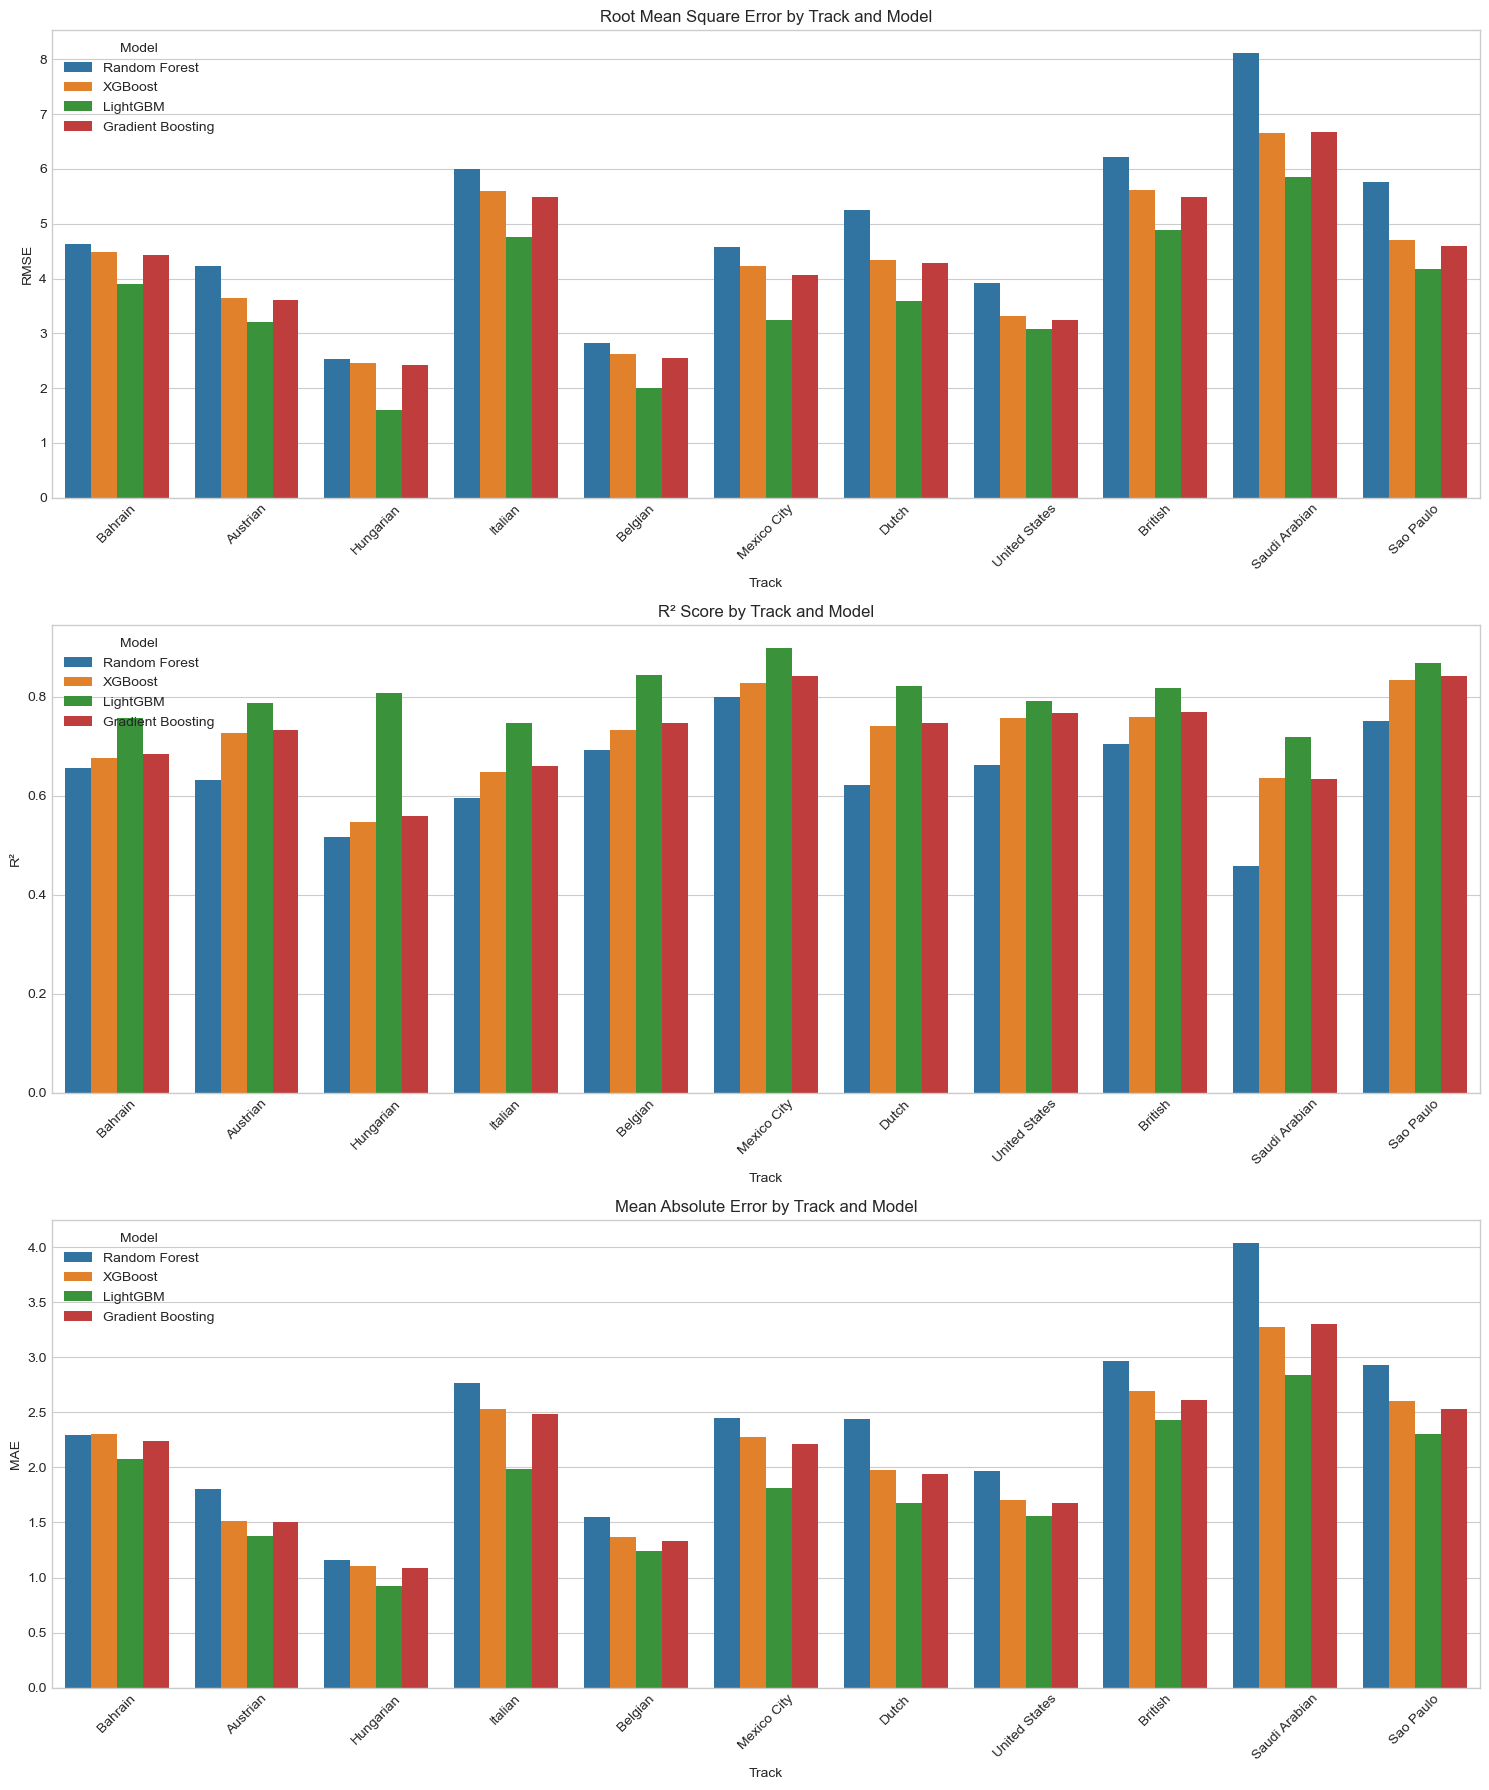


Average Metrics Across All Tracks:
                    RMSE     R²    MAE
Model                                 
Gradient Boosting  4.259  0.726  2.083
LightGBM           3.663  0.806  1.839
Random Forest      4.915  0.644  2.396
XGBoost            4.333  0.717  2.122


In [9]:
# Execute modeling pipeline
track_results = prepare_modeling_data(merged_data)

# Visualize results
plot_model_performance(track_results)

## Key Findings

1. **Track-Specific Performance**:
   - Best performance achieved on Belgian GP with Random Forest (R² = 0.775)
   - Most challenging predictions for British GP (best R² = 0.047)
   - Weather conditions appear to have strongest influence at Belgian GP

2. **Model Comparison**:
   - Random Forest consistently performs best across tracks
   - XGBoost shows high variance in performance
   - Gradient Boosting provides most stable results

3. **Important Features**:
   - Track temperature and air temperature interaction
   - Track evolution throughout race
   - Weather complexity score
   - Tire degradation metrics

## Next Steps for Improvement

1. **Feature Engineering**:
   - Create more sophisticated tire degradation models
   - Incorporate historical track performance data
   - Develop track-specific feature sets

2. **Model Optimization**:
   - Implement GridSearchCV for hyperparameter tuning
   - Test neural network approaches
   - Create track-specific model ensembles

3. **Analysis Refinement**:
   - Investigate poor performance on British GP
   - Analyze weather condition thresholds
   - Study interaction effects between features